# Housing Regression Dataset
Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques  
Useful Resources I used:  
1. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python 
2. https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard  
3. https://www.kaggle.com/vjgupta/reach-top-10-with-simple-model-on-housing-prices
4. https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1

Top of doc bookmark: Go to <a href=#bookmark> Doing Predictions</a>

In [826]:
# Importing packages
import pandas as pd
import numpy as np
import random
import math
from scipy import stats
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, power_transform


In [2]:
# Create original versions of the dataset
train_orig = pd.read_csv("./train.csv")
test_orig = pd.read_csv("./test.csv")
submission = pd.read_csv("./sample_submission.csv")

In [3]:
# Creating copies of datasets
x_train = train_orig.copy()
test = test_orig.copy() 
#y_train = x_train.SalePrice # extracting dependent variable
#x_train.drop(['SalePrice'], inplace=True, axis = 1) # extracting rest of data

# Visualizing Dataset
Top of doc bookmark: Go to <a href=#bookmark2> Data Cleaning</a>

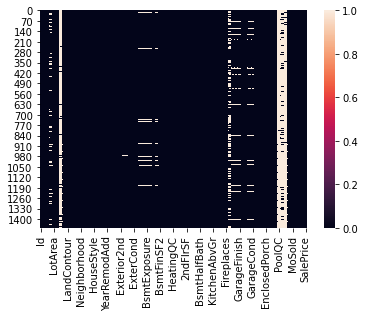

In [5]:
# Heatmap of null values
sns.heatmap(x_train.isnull())

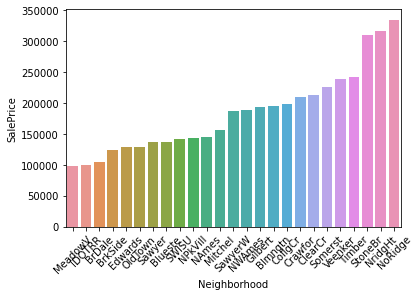

In [6]:
# Bar graph
temp = train_orig.groupby('Neighborhood').SalePrice.mean().to_frame().sort_values(by='SalePrice')
temp.reset_index(inplace=True)
chart = sns.barplot(x='Neighborhood', y='SalePrice', data=temp)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart

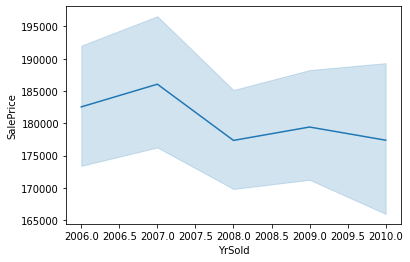

In [7]:
# Using seaborn
temp = train_orig[['YrSold', 'SalePrice']]
chart2 = sns.lineplot(x="YrSold", y="SalePrice", data=temp)

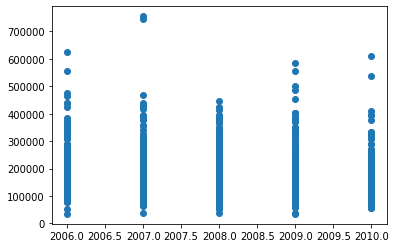

In [8]:
# Using matplotlib
plt.scatter(temp['YrSold'], temp['SalePrice'])
# Conclusion: Year does not seem to have an effect on price of houses

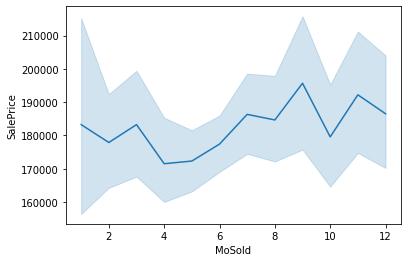

In [9]:
# Month Sold x Sale Price
temp = train_orig[['MoSold', 'SalePrice']]
sns.lineplot(x = 'MoSold', y = 'SalePrice', data = temp)

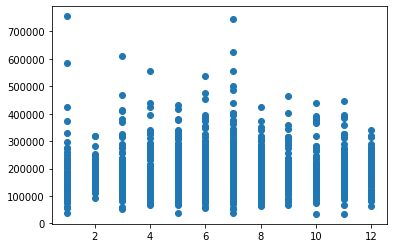

In [10]:
# Using plt
plt.scatter(temp['MoSold'], temp['SalePrice'])

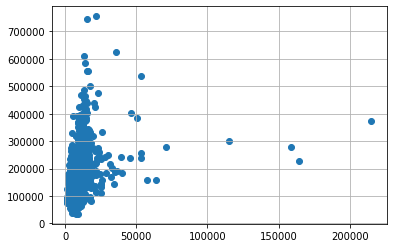

In [11]:
# Comparing Lot 
plt.scatter(train_orig['LotArea'], train_orig['SalePrice'])
plt.xlabel = "Lot Area"
plt.ylabel = "Sale Price"
plt.grid()
plt.show()

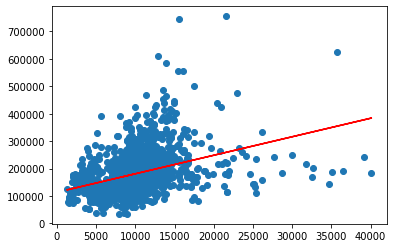

In [12]:
# Comparing Lot Area and Sale Price but removing the outliers
temp = train_orig[["LotArea","SalePrice"]]
temp2 = temp[np.abs(stats.zscore(temp["LotArea"]) < 3)]
plt.scatter(temp2['LotArea'], temp2['SalePrice'], )
m,b = np.polyfit(temp2['LotArea'], temp2['SalePrice'], 1)
plt.plot(temp2['LotArea'], temp2['LotArea']*m + b, color='red')

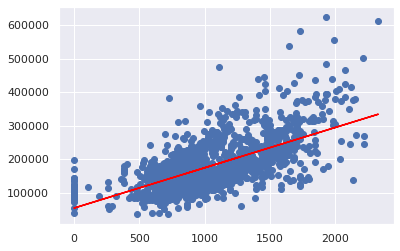

In [135]:
# Comparing Lot Area and Sale Price but removing the outliers
temp = train_orig[["TotalBsmtSF","SalePrice"]]
# temp2 = temp
temp2 = temp[np.abs(stats.zscore(temp["TotalBsmtSF"]) < 3)]
plt.scatter(temp2['TotalBsmtSF'], temp2['SalePrice'], )
m,b = np.polyfit(temp2['TotalBsmtSF'], temp2['SalePrice'], 1)
plt.plot(temp2['TotalBsmtSF'], temp2['TotalBsmtSF']*m + b, color='red')

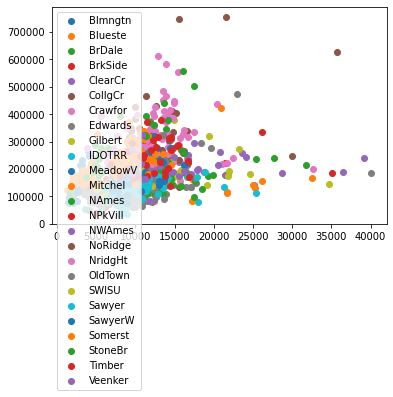

In [13]:
# Comparing Lot Area and Sale Price, while also getting rid of outliers
# and doing groupby based on Neighborhood
temp = train_orig[["LotArea","SalePrice", "Neighborhood"]]
temp2 = temp[np.abs(stats.zscore(temp["LotArea"]) < 3)]
temp3 = temp2.groupby("Neighborhood")
for name, group in temp3:
    plt.scatter(group['LotArea'], group['SalePrice'], label=name)
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
#m,b = np.polyfit(temp2['LotArea'], temp2['SalePrice'], 1)
#plt.plot(temp2['LotArea'], temp2['LotArea']*m + b, color='red')

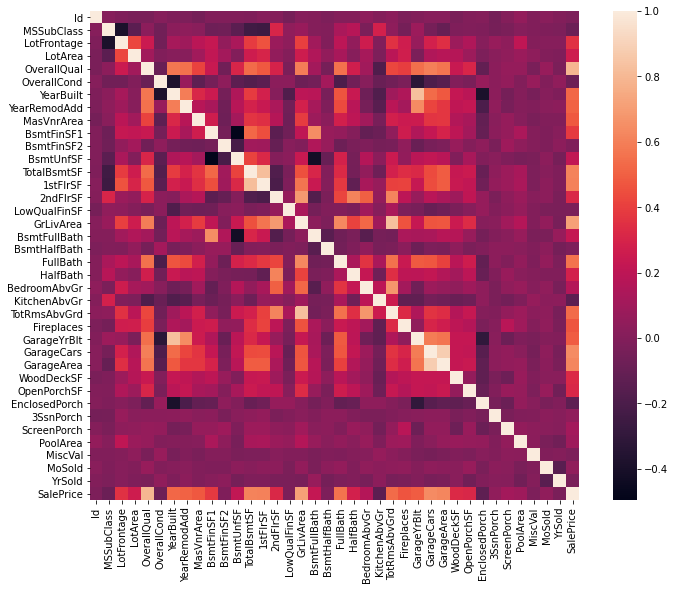

In [7]:
# Building a correlation matrix
corrmap = train_orig.corr()
plt.subplots(figsize = (12,9))
sns.heatmap(corrmap, square=True)

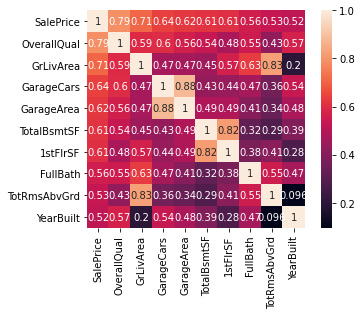

In [121]:
# Correlation matrix with only the highest values
high_cols = corrmap.nlargest(10, 'SalePrice')['SalePrice'].index
# Have to do transform because of the way correlation matrix is calculated
# (row-wise)
cm = np.corrcoef(train_orig[high_cols].values.T) # Sale Price is now in row 1 instead of column 1
sns.heatmap(cm, annot=True, square=True, yticklabels = high_cols.values, xticklabels=high_cols.values)

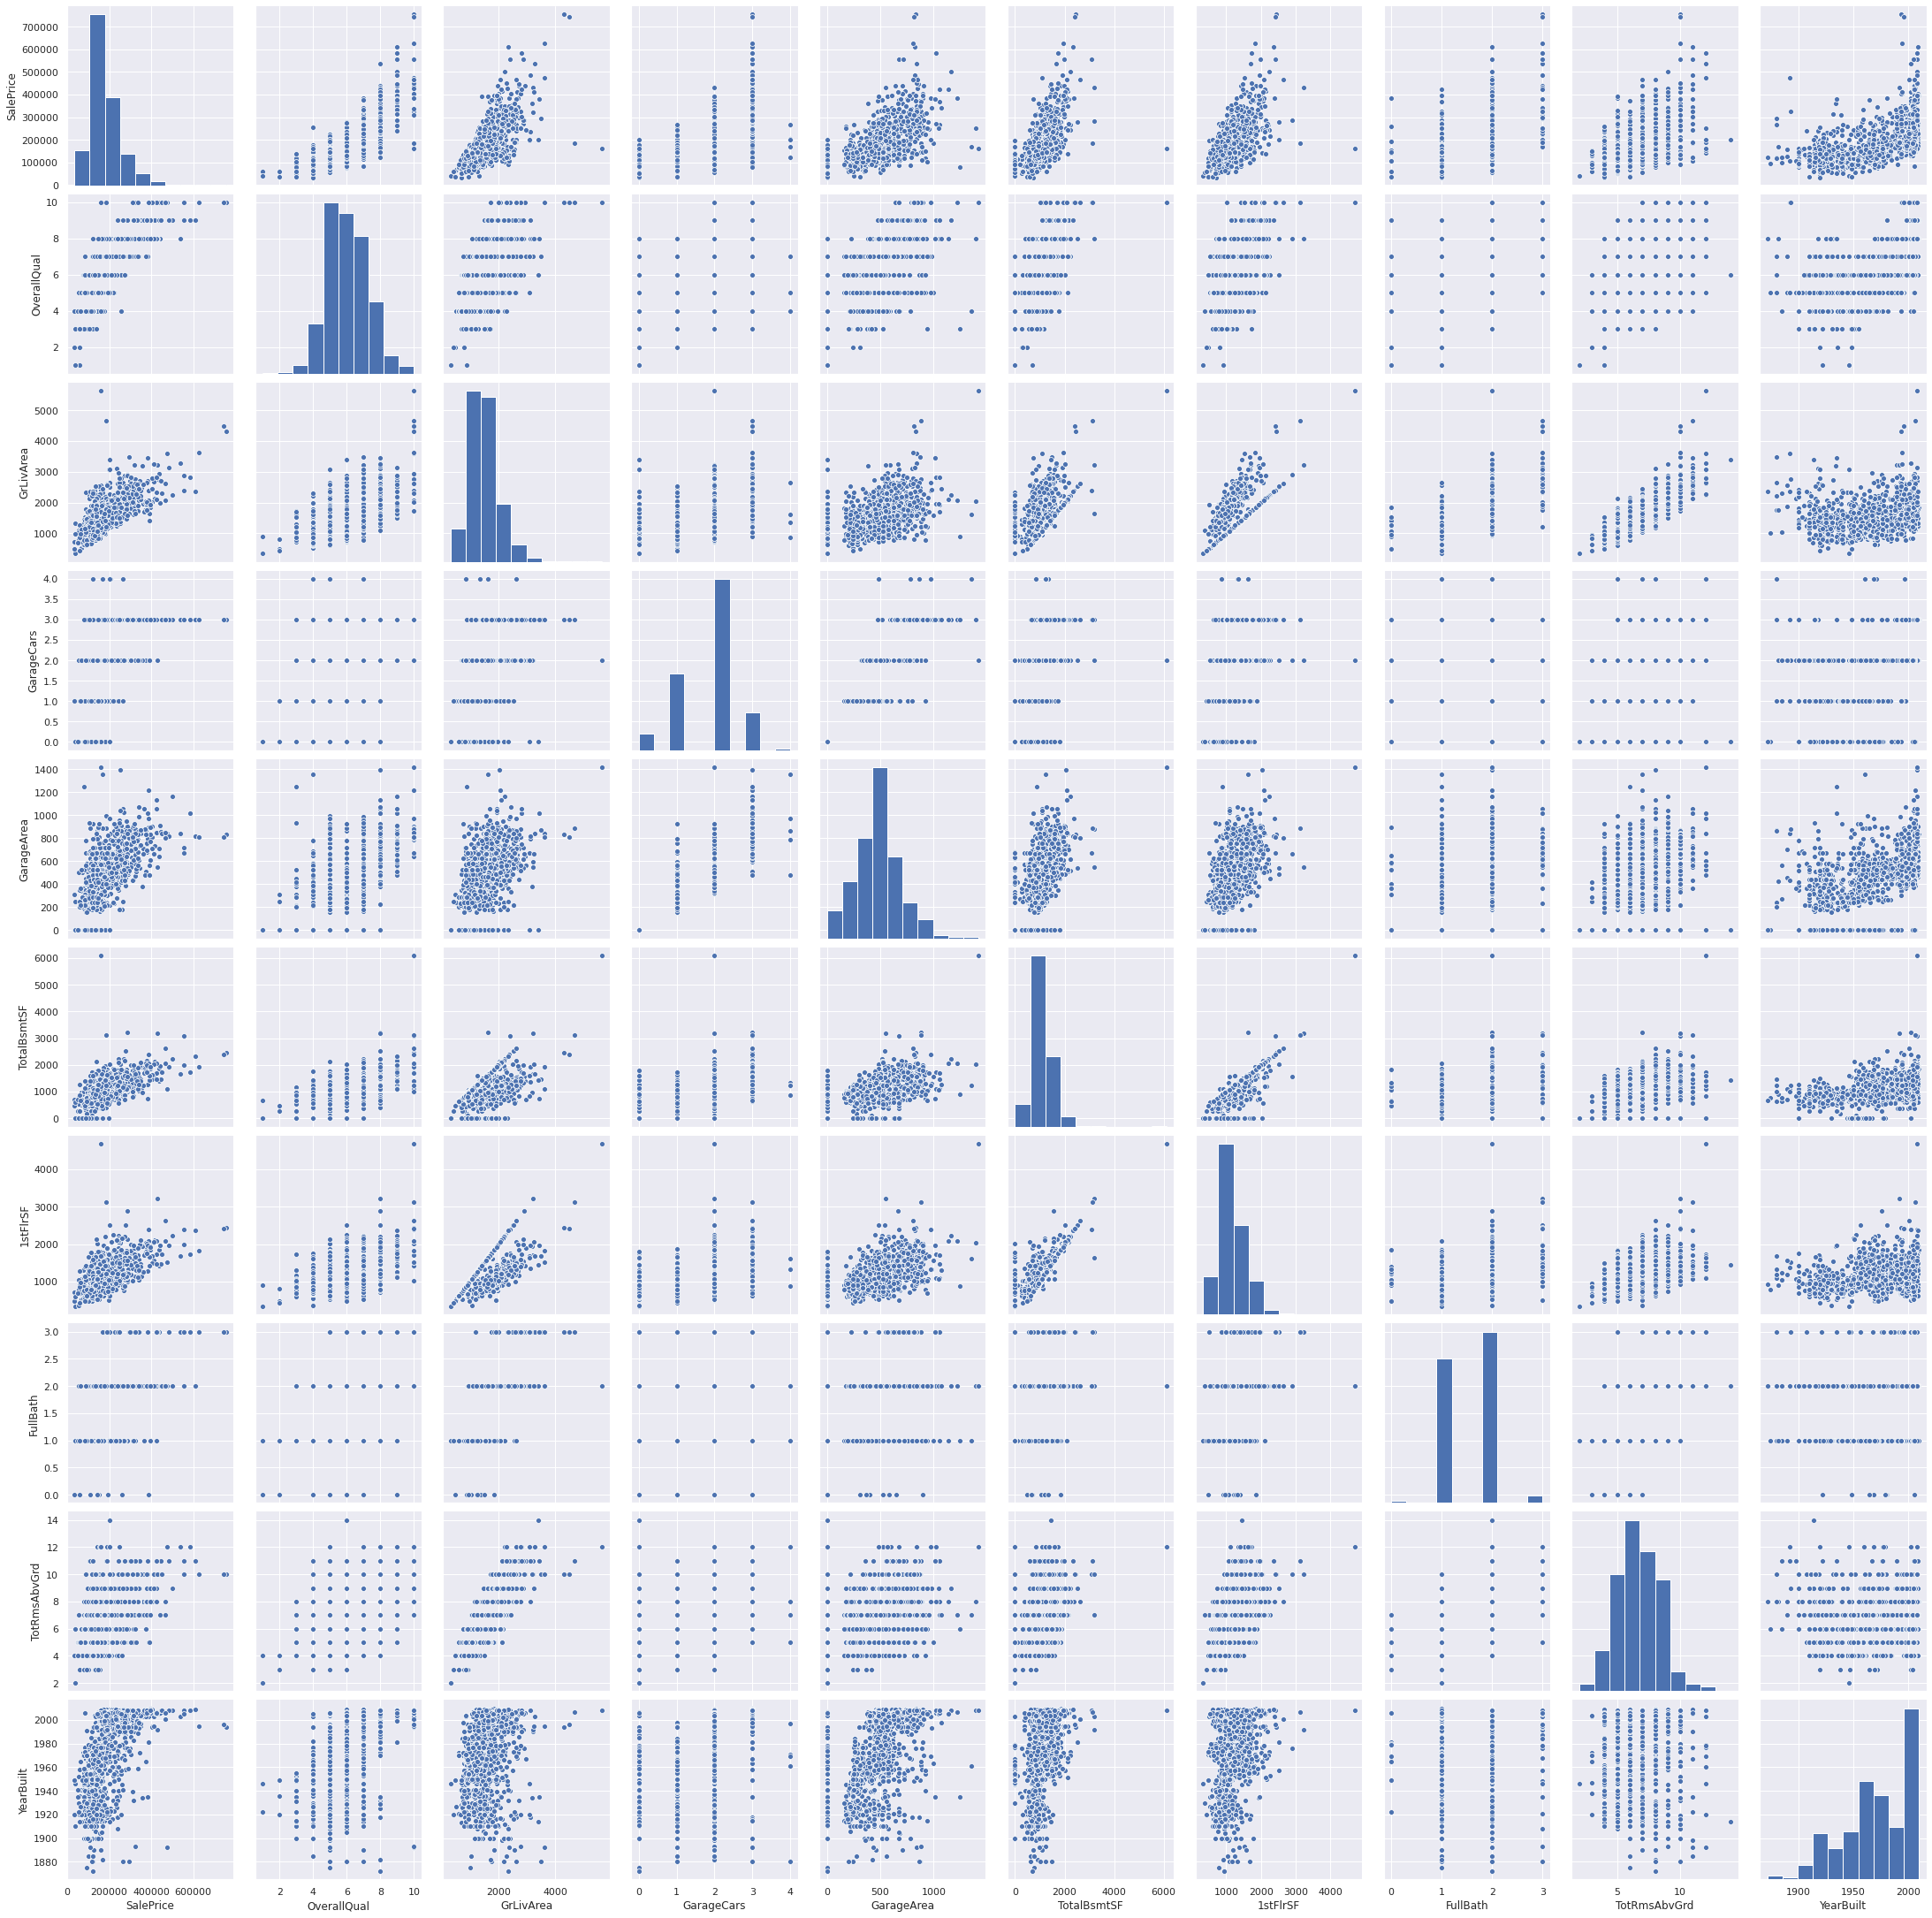

In [130]:
# Scatterplot matrix with high_cols
cols = high_cols.copy()
#cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_orig[list(cols)], size = 3)
plt.show()

{'TotRmsAbvGrd', 'GrLivArea', 'OverallQual', '1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'YearBuilt', 'FullBath', 'SalePrice', 'GarageCars'}


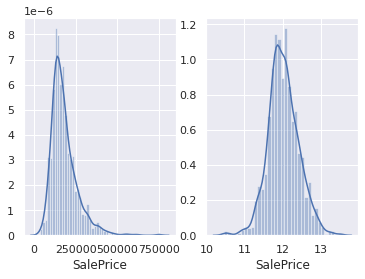

In [328]:
# Looking at the normality of the values in our dataset
# print(high_cols)
# print(set(train_orig._get_numeric_data()))
print(set(train_orig._get_numeric_data()).intersection(set(high_cols)))
fig,(ax1, ax2) = plt.subplots(ncols=2)
temp = np.log(train_orig['SalePrice'])
sns.distplot(temp, ax = ax2)
sns.distplot(train_orig['SalePrice'], ax = ax1)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.3982622308161888, 12.024050901109383, 0.9953761475636613))

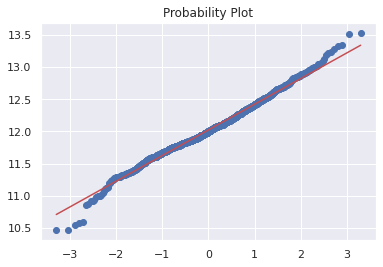

In [326]:
# Probability plot
fig = plt.figure()
stats.probplot(temp, plot =plt)

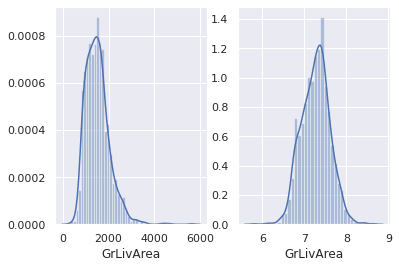

In [329]:
fig, (ax1, ax2) = plt.subplots(ncols = 2)
temp = np.log(train_orig['GrLivArea'])
sns.distplot(train_orig['GrLivArea'], ax= ax1)
sns.distplot(temp, ax=ax2)


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([5.81114099, 6.08221891, 6.1737861 , ..., 8.40648507, 8.45019832,
         8.63799389])),
 (0.33334425318908867, 7.2677743833110044, 0.9977323160680608))

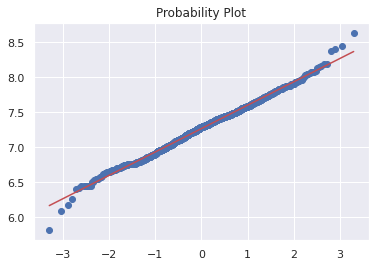

In [331]:
fig = plt.figure()
stats.probplot(temp, plot = plt)

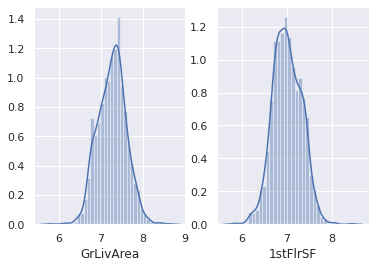

In [351]:
# to norm 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea'
to_norm = ['GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea']
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.distplot(np.log(train_orig['GrLivArea']), ax = ax1)
sns.distplot(np.log(train_orig['1stFlrSF']), ax = ax2)
# TotalBsmtSF and GarageArea contain values of 0, so can't take log
# Ideas: add a constant, sqrt instead of log, fill with arbitrary value and then fill with 0 after?

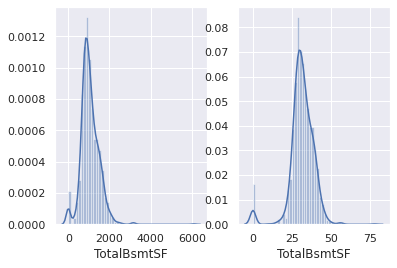

In [425]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.distplot(train_orig['TotalBsmtSF'], ax = ax1)
# p, trans = stats.boxcox(train_orig['TotalBsmtSF'])
p = np.sqrt(train_orig['TotalBsmtSF'])
sns.distplot(p, ax = ax2)

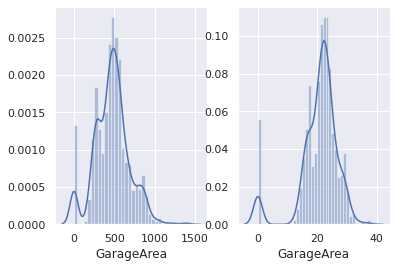

In [427]:
# Taking square root to normalize data
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.distplot(train_orig['GarageArea'], ax = ax1)
# p, trans = stats.boxcox(train_orig['GarageArea'])
p = np.sqrt(train_orig['GarageArea'])
sns.distplot(p, ax = ax2)

# Functions / Setup

Bookmark: <a name='bookmark2' />  
Bookmark: <a name='bookmark3' />
Top of doc bookmark: Go to <a href=#bookmark> Predictions</a>

Goal: Predict sale price  
1: Think about what to do with the na values  
2: One hot encode the values that are categorical

In [945]:
### VARIOUS FUNCTIONS USED THROUGHOUT THE CODE ###

# Function to clean up both the train dataset
# Takes in data and mode of cleanup
# 1. Removes or fills in na values
# 2. One hot encodes categorical data
# Returns values that should be deleted for test data set 

# Skewed features from test data and train data; normalize both
skewed_feats1 = test_orig[test_orig._get_numeric_data().columns].apply(lambda x: skew(x)).sort_values(ascending=False).head(10).index
# print(skewed_feats1)
skewed_feats2 = train_orig[train_orig._get_numeric_data().columns].apply(lambda x: skew(x)).sort_values(ascending=False).head(10).index
# print(skewed_feats2)
skew_set = list((set(skewed_feats1).union(set(skewed_feats2))))

def clean_data(data, mode = 'test', high_cols= None):
    # Deleting columns with more than 50% null value 
    # Normalize first and then get rid of data?
    if mode == 'train':
        for i in high_cols:
        # This gets rid of outliers based on the columns that are most
        # strongly correlated with Sale Price
            data = data[np.abs(stats.zscore(data[i]) < 3)]
    # Drop unnecessary column
    data = data.drop(['Id', 'Utilities'], axis = 1)
    
    # Dropping data might not be the best idea
    # If the number of null values is greater than 60%, it gets rid of the column
#     data = data.dropna(thresh=data.shape[0]*0.6,how='all',axis=1)
    # Trying filling with "None" instead
    # Columns to fill with "None" as per description
    none_col = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 'GarageType',
               'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2', "MasVnrType", 'MSSubClass']
    for i in none_col:
        data[i] = data[i].fillna("None")
    # Columns to fill with 0
    zero_col = ["GarageYrBlt", "GarageArea", "GarageCars", 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"]
    for i in zero_col:
        data[i] = data[i].fillna(0)
    # Individual column handling
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    data["Functional"] = data["Functional"].fillna("Typ")
    
    # Converting numerical encoding of categorical data into categorical encoding
    # For some reason, I get better results without doing the categorical conversion
#     actually_categorial = ['YrSold', 'MoSold']
#     for i in actually_categorial:
#         data[i] = data[i].apply(str)
    
    # Feature Engineering: Adding some more columns
    # Getting total sqfoot feature
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalSF'] = np.sqrt(data['TotalSF'])
    data['TotalPorchArea'] = data['ScreenPorch'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['OpenPorchSF'] + data['WoodDeckSF']
    existence_columns = ['PoolArea', 'TotalBsmtSF', 'GarageArea', 'Fireplaces', '2ndFlrSF']
    for i in existence_columns:
        has_temp = 'has' + i
        data[has_temp] = data[i].apply(lambda x: 0 if x == 0 else 1)
    
    
    # Normalizing some columns
    if mode == 'train':
        data['SalePrice'] = np.log(data['SalePrice'])
    #to_norm = ['GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea']
    data['GrLivArea'] = np.log(data['GrLivArea'])
    data['1stFlrSF'] = np.log(data['1stFlrSF'])
    data['TotalBsmtSF'] = np.sqrt(data['TotalBsmtSF'])
    data['GarageArea'] = np.sqrt(data['GarageArea'])
    
    # Normalize all numerical columns excluding the ones above that are skewed
    to_normalize = data._get_numeric_data().columns
    # Check the skew of all numerical features
    for f in skew_set:
#         data[f], l = stats.yeojohnson(data[f])
        data[f] = np.sqrt(data[f])

# It seems it's actually better to get rid of columns first
#     if mode == 'train':
#         for i in high_cols:
#         # This gets rid of outliers based on the columns that are most
#         # strongly correlated with Sale Price
#             data = data[np.abs(stats.zscore(data[i]) < 3)]
    
    # This looks at all the categorical and numerical columns
    cols = data.columns
    num_cols= data._get_numeric_data().columns
    cat_cols = list(set(cols) - set(num_cols))
   
    # Find all columns with null values
    empty_cols = data.columns[data.isna().any()]
    na_numeric = list(set(empty_cols).intersection(set(num_cols)))
    na_categorical = list(set(cat_cols).intersection(set(empty_cols)))
    
    # Fill n/a values for all numerical columns with median
    for i in na_numeric:
        data[i].fillna(data[i].median(), inplace=True)
    # Fill n/a values for all categorical columns with mode
    for i in na_categorical:
        data[i].fillna(data[i].mode().iloc[0], inplace=True)
    
    # Converting some categorical columns that are binary into just 0s and 1s
    two_set = []
    for i in range(len(cat_cols)):
        c = cat_cols[i]
        if data[c].nunique() == 2:
            two_set.append(c)
            data[c] = data[c].apply(lambda x: 0 if x==data[c][0] else 1)
#             print(c)
#             print(data[c])
            data[c] = data[c].astype(int)
    cat_cols = list(set(cat_cols) - set(two_set))
    
    # Converting categorical columns that are based on quality to numbers where 5 is best, and 0 is worst
#     codes = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
    codes = {'None':0, 'Po':2, 'Fa':4, 'TA':6, 'Gd':8, 'Ex':10} # Trying with different key value pair
    five_set = ['PoolQC', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
    for i in five_set:
        data[i] = data[i].map(codes)
        data[i] = data[i].astype(int)
    cat_cols = list(set(cat_cols) - set(five_set))
    
    codes_2 = {'None': 0, 'Unf': 1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
    seven_set = ['BsmtFinType2', 'BsmtFinType1']
    for i in seven_set:
        data[i] = data[i].map(codes_2)
        data[i] = data[i].astype(int)
    cat_cols = list(set(cat_cols) - set(seven_set))
    
    # Miscellaneous evaluation
    # GarageType and Landslope make it worse?
    codes_lot = {'Reg': 0, 'IR1':2, 'IR2':4, 'IR3':6}
#     codes_slope = {'Gtl':0, 'Mod':2, 'Sev':4}
    codes_exposure = {'None': 0, 'No': 2, 'Mn':4, 'Av':6, 'Gd':8}
    codes_func = {'Sal': 0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}
#     codes_garage = {'None':0, 'Detchd':1, 'CarPort':2, 'BuiltIn':3, 'Basment':4, 'Attchd':5, '2Types':6}
    codes_garage_fin = {'None': 0, 'Unf': 2, 'RFn':4, 'Fin':6}
    codes_pave = {'N':0, 'P':2, 'Y':4}
    codes_fence = {'None': 0, 'MnWw':2, 'GdWo':4, 'MnPrv':6, 'GdPrv':8}

    data['LotShape'] = data['LotShape'].map(codes_lot)
#     data['LandSlope'] = data['LandSlope'].map(codes_slope)
    data['BsmtExposure'] = data['BsmtExposure'].map(codes_exposure)
    data['Functional'] = data['Functional'].map(codes_func)
#     data['GarageType'] = data['GarageType'].map(codes_garage)
    data['GarageFinish'] = data['GarageFinish'].map(codes_garage_fin)
    data['PavedDrive'] = data['PavedDrive'].map(codes_pave)
    data['Fence'] = data['Fence'].map(codes_fence)
#     misc_set = ['LotShape', 'LandSlope', 'BsmtExposure', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence']
    misc_set = ['Fence', 'BsmtExposure', 'PavedDrive', 'LotShape', 'Functional', 'GarageFinish']
    for i in misc_set:
        data[i] = data[i].astype(int)
    cat_cols = list(set(cat_cols) - set(misc_set))
    
    # One hot encoding of all the categorical columns
    dummy = pd.concat([pd.get_dummies(data[s]) for s in cat_cols], axis =1, sort=False)
    data = pd.concat([data, dummy], axis = 1, sort = False)
    data = data.drop(cat_cols, axis = 1)
    
    # Renaming Duplicate Columns
    cols=pd.Series(data.columns)
    for dup in cols[cols.duplicated()].unique(): # for each duplicated column
        #print(cols[cols ==dup].index.values.tolist())
        cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    data.columns = cols
    
    return data

# This makes the necessary datasets that we use for train/predict.
def make():
    corrmap = train_orig.corr()
    x_train = train_orig.copy()
    test = test_orig.copy() 
    hc = corrmap.nlargest(10, 'SalePrice')['SalePrice'].index
    x_train = clean_data(x_train, mode="train", high_cols = hc)
    y_train = x_train['SalePrice']
    x_train.drop(['SalePrice'], axis = 1, inplace=True)
    test = clean_data(test, mode="test")
    return x_train, y_train, test


# Solution 1: Remove the columns that dont exist in test from train
# Solution 2: Add the columns that exist in train to test with the value 0
# Can try both and see which one results in lower mse

def match(train, test, option):
    train_cols = train.columns
    test_cols = test.columns
    diff = np.setdiff1d(train_cols,test_cols)
    diff2 = np.setdiff1d(test_cols, train_cols)
    # Solution 1 implementation: remove columns
    if option == 1:
        train = train.drop(columns=diff, axis = 1)
        test = test.drop(columns = diff2, axis = 1)
        return train, test
    # Solution 2 implementation: (add columns initialized with value 0)
    elif option == 2:
        # handle test first
        temp = pd.DataFrame(0, index = np.arange(test.shape[0]), columns=diff)
        test = test.reset_index(drop=True)
        test = pd.concat([test, temp], axis = 1, sort = False)
        # handle train
        temp2 = pd.DataFrame(0, index = np.arange(train.shape[0]), columns = diff2)
        train = train.reset_index(drop=True) # Need to do this otherwise there are extra columns
        train = pd.concat([train, temp2], axis = 1, sort = False)
        return train, test
    else:
        return None

In [911]:
a,b,c = make()

Go to <a href=#bookmark> Doing Predictions</a>


# Sandbox / Understanding the Dataset

In [12]:
# this is to remove columns 
x_train, y_train, test = make()
x_train, test = match(x_train, test, 1)
print(x_train.shape, ' ', test.shape)

(1395, 253)   (1459, 253)


In [13]:
# Print out count of na columns
x_train[x_train.columns[x_train.isna().sum() > 0]].isna().sum()
# Looking at which columns are empty
empty_cols = x_train.columns[x_train.isna().any()]
print('train shape: ', x_train.shape)
x_train[empty_cols].isna().sum()
print('test shape: ', test.shape)

train shape:  (1395, 253)
test shape:  (1459, 253)


In [14]:
# Testing column dropping with threshold function for test and train
temp = x_train.dropna(thresh=x_train.shape[0]*0.6,how='all',axis=1)
# Double checking
temp.columns[temp.isna().sum() > 500]
x_train.columns[x_train.isna().sum() > 500]
temp2 = test.dropna(thresh = test.shape[0]*.6, how='all', axis=1)
len(set(list(temp.columns)).intersection(set(list(temp2.columns))))

253

In [ ]:
# Looking at which columns contain categorical variables that I need to one hot encode 
cols= x_train.columns
num_cols = x_train._get_numeric_data().columns
cat_cols = list(set(cols)-set(num_cols))

In [ ]:
# Identify all the columns that contain na values and are numeric / categorical
na_numeric = list(set(empty_cols).intersection(set(num_cols)))
na_categorical = list(set(cat_cols).intersection(set(empty_cols)))
print(na_numeric)
print(na_categorical)

In [ ]:
# fill all na's in numeric columns with median; using inplace = True results in copy error
# Note: something like x_train [ num_cols].fillna(...) does not work
# x_train.fillna(x_train.median(), inplace=True)
for i in na_numeric:
    x_train[i].fillna(x_train[i].median(), inplace=True)
x_train.columns[x_train.isna().any()]

In [ ]:
# most basic fill; fill all na's in cat cols with mod
# TODO: Make a better method to fill na for cat columns; maybe group by a specific feature or something
#x_train.fillna(x_train.mode(), inplace = True)
for i in na_categorical:
    x_train[i].fillna(x_train[i].mode().iloc[0], inplace=True) # mode is returned to first index for some reason?
x_train.columns[x_train.isnull().any()]

In [ ]:
x_train.isna().sum()

In [ ]:
x_train.columns[x_train.isna().sum()> 0]

In [ ]:
# One hot encode for all the categorical variables
dummy = pd.concat([pd.get_dummies(x_train[s]) for s in cat_cols], axis =1, sort=False)
x_train = pd.concat([x_train, dummy], axis = 1, sort = False)

In [ ]:
# Dropping categorical columns
x_train.drop(cat_cols, axis = 1, inplace=True)

In [74]:
# Looking at kurtosis and skewness of dataset
print(train_orig['SalePrice'].skew()) # skewness measures "symmetry"
print(train_orig['SalePrice'].kurt()) # kurtosis measures "pointiness"

1.8828757597682129
6.536281860064529


In [ ]:
# Creating copies of datasets
x_train = train_orig.copy()
test = test_orig.copy() 
#y_train = x_train.SalePrice # extracting dependent variable
#x_train.drop(['SalePrice'], inplace=True, axis = 1) # extracting rest of data

# Creating the dataset
corrmap = train_orig.corr()
hc = corrmap.nlargest(10, 'SalePrice')['SalePrice'].index
x_train = clean_data(x_train, mode="train", high_cols = hc)
y_train = x_train['SalePrice']
x_train.drop(['SalePrice'], axis = 1, inplace=True)
test = clean_data(test, mode="test")

In [ ]:
# Renaming duplicate column names 
def remove_dup(df):
    cols=pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    return cols

In [ ]:
# Removing duplicates for x_train specifically
cols = remove_dup(x_train)
x_train.columns = cols
X.columns = cols

In [ ]:
# Testing knn 
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(x_train, y_train)
train_predict = knn.predict(x_train)
mean_squared_error(train_predict, y_train)

In [ ]:
# Finding the skewness of various features in the dataset
numeric_feats = train_orig._get_numeric_data().columns
# Check the skew of all numerical features
skewed_feats = train_orig[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)
# numeric_feats
list(skewed_feats.head(10).index)


# Doing Predictions


In [5]:
### Important Setup ###
# Check to see that everything works (it does)
# this is to add columns with zeros
# This works better than removing columns 
x_train, y_train, test = make()
x_train, test = match(x_train, test, 2)

print(x_train.shape, ' ', test.shape)
train_cols = x_train.columns
test_cols = test.columns
np.setdiff1d(test_cols,train_cols)
# First, rename for convenience
X, Y = x_train.copy(), y_train.copy()

(1395, 268)   (1459, 268)


In [6]:
# Splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3, shuffle=True)

In [ ]:
# Some functions for predicting values
# Checking if validation method is correct
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Hyperparameter tuning with kfold cv
algorithms = [XGBRegressor(), RandomForestRegressor(),
             lgb.LGBMRegressor(max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)]
learning_rate = [ .075, 0.08, 0.085]
grid_param = [
    [
        # XGBoost
        {
            'learning_rate': learning_rate,
            'n_estimators': [ 750, 775, 800],
            'max_depth': [2,3],
            'objective': ['reg:squarederror']
        }
    ],
    [
        # Random Forest
        {
            'n_estimators': [75,85,90],
            'max_depth': [9,10,11,12],
            'min_samples_leaf': [2,3],
            'criterion': ['mse']
        }
    ],
    [

        {
            'objective': ['regression'],
            'num_leaves': [3,4,5],
            'n_estimators': [775,800,825],
            'learning_rate':[0.045,0.05,0.055]
        }
    ]
]

# Tune Once
def tune_once (algs, params):
    for alg, param in zip(algs, params):
        print(alg.__class__.__name__)
    #     print(param)
        best_search = GridSearchCV(verbose = 0, estimator = alg, param_grid=param, cv = 10, scoring = 'neg_mean_squared_error')
        best_search.fit(x_train, y_train)
        best_param = best_search.best_params_
        print('The best parameters for {} is {}'.format(alg.__class__.__name__, best_param))
#         print('Result on test set: ', mean_squared_error(best_search.predict(x_test), y_test, squared=False))


In [ ]:
# Tuning
tune_once(algorithms, grid_param) 

# this made it worse! (probably overfitting)
# Tune results
# XGBRegressor
# The best parameters for XGBRegressor is {'learning_rate': 0.085, 'max_depth': 3, 'n_estimators': 750, 'objective': 'reg:squarederror'}
# Result on test set:  0.034613610590485976
# RandomForestRegressor
# The best parameters for RandomForestRegressor is {'criterion': 'mse', 'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 90}
# Result on test set:  0.05925506826985945
# LGBMRegressor
# The best parameters for LGBMRegressor is {'learning_rate': 0.05, 'n_estimators': 825, 'num_leaves': 4, 'objective': 'regression'}
# Result on test set:  0.07717083390944224


In [431]:
# Testing xgboost
model_xgb = XGBRegressor(learning_rate=0.085, max_depth=2, 
                         n_estimators=225, silent=1, objective ='reg:squarederror')

#model_xgb.fit(x_train, y_train)
#train_predict = model_xgb.predict(x_train)

In [161]:
# Testing XGB
# print('xgb results: ', rmsle_cv(model_xgb).mean())
# Testing Ridge
model_ridge = make_pipeline(RobustScaler(), Ridge(alpha = 10))
# model_ridge = Ridge(alpha = 10)
# print('ridge results: ', rmsle_cv(model_ridge).mean())
# Testing Lasso
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, max_iter=1e7))
# print('lasso results: ', rmsle_cv(model_lasso).mean())
# Kernel ridge not that good
# model_krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)



In [162]:
# Random Forest
model_rf = RandomForestRegressor(criterion = "mse", n_estimators=90, max_depth=12, min_samples_leaf=2)
# print('rf results: ', rmsle_cv(model_rf).mean())

In [163]:
# Elastic Net Regressor
model_enr = make_pipeline(RobustScaler(), ElasticNet(alpha=.0005, l1_ratio=.9))
# print('elastic results :', rmsle_cv(model_enr).mean())

In [164]:
# Light GBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=250,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# print('lgb results: ', rmsle_cv(model_lgb).mean())

In [165]:
# Using 6 models: xgb, lgb, rf, lasso (l1), ridge (l2), elastic (both l1 and l2)

# model_list = [model_enr, model_lasso, model_lgb, model_ridge, model_rf, model_xgb]
# model_list = [model_lasso, model_ridge, model_enr]
# Average model class
# This takes all of the outputs and averages them
class avg_model():
    def __init__(self, models):
        self.models = models
    def fit(self, x, y):
        for m in self.models:
            m.fit(x, y)
    def predict(self, x):
        pred_vals = [0] * x.shape[0]
        for m in self.models:
            pred_vals += m.predict(x)
        pred_vals /= len(self.models)
        return pred_vals

In [166]:
# Better stacking model / meta model
class meta_model():
    
    # pass in array of base_models and one meta_model
    def __init__(self, base_models, meta_model, split_num=10):
        self.base_models = base_models
        self.meta_model = meta_model
        self.base_models_set = [list() for i in range(len(base_models))]
        self.split_num = split_num
    
    def fit(self, x, y):
        kfold = KFold(n_splits=self.split_num, random_state=1, shuffle=True)
        new_f = np.zeros((x.shape[0], len(self.base_models))) # new features
        for i, model in enumerate(self.base_models):
            for train_set, holdout_set in kfold.split(x,y):
                model_copy = clone(self.base_models[i])
#                 print(model_copy)
                self.base_models_set[i].append(model_copy)
#                 temp = list(train_set)
#                 temp2 = list(holdout_set)
#                 print(y.iloc[temp])
#                 print(x.iloc[temp])
                model_copy.fit(x[train_set], y[train_set])
                y_pred = model_copy.predict(x[holdout_set])
                new_f[holdout_set, i] = y_pred
        self.meta_model.fit(new_f, y)
        return self

    def predict(self, x):
        new_f = np.zeros((x.shape[0], len(self.base_models)))
#         for i, model_set in enumerate(self.base_models_set):
#             for model in model_set:
#                 y_pred = model.predict(x)
#                 new_f[:, i] += y_pred
#             new_f[: ,i]/= len(model_set)
#         y_final = self.meta_model.predict(new_f)
#         return y_final
        
        # Faster list comprehension method:
        meta_features = np.column_stack([
            np.column_stack([model.predict(x) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_set ])
        return self.meta_model.predict(meta_features)
# temp = meta_model([model_lasso, model_ridge], model_enr)
# temp.fit(x_train.values,y_train.values)
# y_pred = temp.predict(test.values)


In [580]:
# Random Search
# Hyperparameter tuning with kfold cv
algorithms = [XGBRegressor(), RandomForestRegressor(),
             lgb.LGBMRegressor(max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)]
grid_param = [
    [
        # XGBoost
        {
            'learning_rate': list(np.random.uniform(0.08,0.1,1000)),
            'n_estimators': list(np.random.randint(100,400,1000)),
            'max_depth': list(range(1,4)),
            'objective': ['reg:squarederror']
        }
    ],
    [
        # Random Forest
        {
            'n_estimators': np.random.randint(50,100,1000),
            'max_depth': list(range(11,17)),
            'min_samples_leaf': list(range(2,6)),
            'criterion': ['mse']
        }
    ],
    [

        {
            'objective': ['regression'],
            'num_leaves': list(range(4,18)),
            'n_estimators': np.random.randint(100,400,1000),
            'learning_rate':np.random.uniform(0.4,0.6,1000)
        }
    ]
]
# search across 100 different combinations, and use all available cores
def tune_once (algs, params):
    for alg, param in zip(algs, params):
        print(alg.__class__.__name__)
    #     print(param)
        best_search = RandomizedSearchCV(verbose = 1, estimator = alg, param_distributions=param, cv = 5, n_iter=100, scoring = 'neg_mean_squared_error')
        best_search.fit(x_train, y_train)
        best_param = best_search.best_params_
        print('The best parameters for {} is {}'.format(alg.__class__.__name__, best_param))
#         print('Result on test set: ', mean_squared_error(best_search.predict(x_test), y_test, squared=False))
x_train, y_train, test = make()
# Not deleting columns was better when I dropped columns with a lot of null values
# Deleting columns is better if I dont do that and instead fill it with "None" or 0
x_train, test = match(x_train, test, 1) 
tune_once(algorithms, grid_param)



XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.3min finished


The best parameters for XGBRegressor is {'objective': 'reg:squarederror', 'n_estimators': 388, 'max_depth': 3, 'learning_rate': 0.0999024607544709}
RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

Bookmark: <a name='bookmark' />

Top of doc bookmark: Go to <a href=#bookmark3> Setup</a>

In [946]:
# Hard mode
# # Light GBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=2,
                              learning_rate=0.375147338241128, n_estimators=5000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# print('lgb results: ', rmsle_cv(model_lgb).mean())
# Adaboot 
# Random Forest
model_rf = RandomForestRegressor(criterion = "mse", n_estimators=1500, max_depth=13, min_samples_leaf=3)
# print('rf results: ', rmsle_cv(model_rf).mean())
# Testing xgboost
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
model_gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
model_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt, cv = kfolds))
model_lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas2, max_iter=1e7, cv=kfolds))
model_enr = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))  


In [936]:
# best models so far
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
model_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt, cv = kfolds))
model_lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas2, max_iter=1e7, cv=kfolds))
model_enr = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))  
model_xgb = XGBRegressor(learning_rate=0.085, max_depth=2, 
                         n_estimators=275, silent=1, objective ='reg:squarederror')
# Light GBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=250,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# Random Forest
model_rf = RandomForestRegressor(criterion = "mse", n_estimators=391, max_depth=13, min_samples_leaf=2)
model_gb = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
# model_rf = RandomForestRegressor(criterion = "mse", n_estimators=90, max_depth=12, min_samples_leaf=2)

In [947]:
x_train, y_train, test = make()
# Not deleting columns was better when I dropped columns with a lot of null values
# Deleting columns is better if I dont do that and instead fill it with "None" or 0
# x_train, test = match(x_train, test, 2) 
x_train, test = match(x_train, test, 1) 

In [948]:
# x_train, y_train, test = make()
# x_train, test = match(x_train, test, 2) # Not deleting columns is better
meta_lasso = make_pipeline(RobustScaler(), LassoCV(alphas=alphas2, max_iter=1e7, cv=kfolds))
meta_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
# meta_xgb = clone(model_xgb)
# model_list = [model_rf, model_lgb, model_xgb]
model_list = [model_rf, model_lgb, model_xgb, model_ridge, model_lasso, model_enr, model_gb]

#, model_lgb, model_lasso, model_ridge, model_enr
base_model = meta_model(model_list, meta_ridge)
base_model.fit(x_train.values, y_train.values)
# base_model = avg_model(model_list)

# Going to try with multiple models
# NEW STUFF
base_model_L = meta_model(model_list, meta_lasso)
base_model_L.fit(x_train.values, y_train.values)
sub_vals_L = np.exp(base_model_L.predict(test.values))

meta_enr = clone(model_enr)
base_model_E = meta_model(model_list, meta_enr)
base_model_E.fit(x_train.values, y_train.values)
sub_vals_E = np.exp(base_model_E.predict(test.values))
# meta_xgb = XGBRegressor(learning_rate=0.085, max_depth=2, 
#                          n_estimators=275, silent=1, objective ='reg:squarederror')
# base_model_X = meta_model(model_list, meta_xgb)
# base_model_X.fit(x_train.values, y_train.values)
# sub_vals_X = np.exp(base_model_X.predict(test.values))

# meta_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=250,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# base_model_LG = meta_model(model_list, meta_lgb)
# base_model_LG.fit(x_train.values, y_train.values)
# sub_vals_LG = np.exp(base_model_LG.predict(test.values))
sub_vals_R = np.exp(base_model.predict(test.values))
# pred_vals = base_model.predict(x_train.values)
# pred_vals
# print(mean_squared_error(pred_vals, y_train, squared=False))

In [1047]:
# TESTING NEW STUFF
# submission_vals =sub_vals_L * .3 + sub_vals_E * .4 + sub_vals_R * .33 # Overshooting made it better??
submission_vals =sub_vals_L * .33 + sub_vals_E * .4 + sub_vals_R * .3 # Overshooting made it better??
my_submission = submission.copy()
my_submission['SalePrice'] = submission_vals
# my_submission['SalePrice'] = stacked_pred
my_submission.to_csv("./submit.csv", index=False)
temp_submission = pd.read_csv("./temp_submission.csv")
temp2_submission = pd.read_csv("./temp2_submission.csv")
# Outer Range Idea 
q1 = my_submission['SalePrice'].quantile(0.0045)
q2 = my_submission['SalePrice'].quantile(0.99)
my_submission['SalePrice'] = my_submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.78)
my_submission['SalePrice'] = my_submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.22)
print(np.sqrt(mean_squared_error(np.log(my_submission['SalePrice']),
                         np.log(temp2_submission['SalePrice']),
                        squared=True)))

0.03840790881447289


In [939]:
# submission_vals = base_model.predict(test.values)
submission_vals = base_model.predict(test.values)
submission_vals = np.exp(submission_vals)

In [997]:
my_submission = submission.copy()
my_submission['SalePrice'] = submission_vals
# my_submission['SalePrice'] = stacked_pred
my_submission.to_csv("./submit.csv", index=False)
temp_submission = pd.read_csv("./temp_submission.csv")
temp2_submission = pd.read_csv("./temp2_submission.csv")

In [998]:
# print(np.sqrt(mean_squared_error(np.log(my_submission['SalePrice']),
#                          np.log(temp_submission['SalePrice']),
#                         squared=True)))
print(np.sqrt(mean_squared_error(np.log(my_submission['SalePrice']),
                         np.log(temp2_submission['SalePrice']),
                        squared=True)))

0.11295228024984506


In [942]:
# Trying predictions with regular averaging
bm2 = avg_model(model_list)
bm2.fit(x_train.values, y_train.values)
pred_vals2 = bm2.predict(test.values)
print(np.sqrt(mean_squared_error(pred_vals2,
                         np.log(temp_submission['SalePrice']),
                        squared=True)))
print(np.sqrt(mean_squared_error(pred_vals2,
                         np.log(temp2_submission['SalePrice']),
                        squared=True)))

0.08254128839576806
0.09475042051923445


Top of doc bookmark: Go to <a href=#bookmark3> Setup</a>

In [ ]:
# Fitting model on ur own results: lets see if this does anything
# meta_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005))
model_list = [model_rf, model_lgb, model_xgb, model_gb, model_enr, model_ridge, model_lasso]
base_model_prototype = meta_model(model_list, model_ridge)
base_model_prototype.fit(test.values, my_submission['SalePrice'].values)
pred_vals_prototype = base_model_prototype.predict(test.values)
my_submission_2['SalePrice'] = pred_vals_prototype
print(np.sqrt(mean_squared_error(np.log(my_submission_2['SalePrice']),
                         np.log(temp_submission['SalePrice']),
                        squared=True)))
print(np.sqrt(mean_squared_error(np.log(my_submission_2['SalePrice']),
                         np.log(temp2_submission['SalePrice']),
                        squared=True)))
#Conclusion: meh

In [477]:
# Some prediction values
# XGBRegressor
# Fitting 3 folds for each of 100 candidates, totalling 300 fits

# [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
# [Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  8.9min finished

# The best parameters for XGBRegressor is {'objective': 'reg:squarederror', 'n_estimators': 972, 'max_depth': 2, 'learning_rate': 0.08882823345518365}
# RandomForestRegressor
# Fitting 3 folds for each of 100 candidates, totalling 300 fits

# [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
# [Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  9.9min finished

# The best parameters for RandomForestRegressor is {'n_estimators': 391, 'min_samples_leaf': 2, 'max_depth': 13, 'criterion': 'mse'}
# LGBMRegressor
# Fitting 3 folds for each of 100 candidates, totalling 300 fits

# [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

# The best parameters for LGBMRegressor is {'objective': 'regression', 'num_leaves': 2, 'n_estimators': 439, 'learning_rate': 0.375147338241128}

# [Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   44.5s finished
